# A/B Test experiment design

## References

Instructions: https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub

Template: https://docs.google.com/document/d/16OX2KDSHI9mSCriyGIATpRGscIW2JmByMd0ITqKYvNg/edit

Baseline values: https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0


##  Invariant metrics
Metrics that should not change in the control and experimental groups:
- **Number of cookies** (number of unique cookies to view the course overview page): cannot be affected by the experiment because users made a decision to visit the page before they were asked the question.
- **Number of clicks** (number of unique cookies to click the "Start free trial" button, which happens before the free trial screener is triggered): cannot be affected by the experiment because users clicked the button before they were asked the question.
- **Click-through-probability** (number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page): cannot be affected by the experiment because it depends on number of cookies, that is invariant too.

## Evaluation metrics
Metrics that should change in the control and experimental groups:
- **Gross conversion** (number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button): can be affected by the experiment because users could decide to enroll in the free trial in the experimental group less than in the control group because they don't plan to spend 5+ hours per week.
- **Retention** (number of user-ids to remain enrolled past the 14 days trial divided by number of user-ids to complete checkout): can be affected by the experiment because enrolled users should be more aware of the time they should spend on studying and so they could be more prone to pay past the free trial.
- **Net conversion** (number of user-ids to remain enrolled past the 14 days trial divided by the number of unique cookies to click the "Start free trial" button): can be affected by the experiment for the same reason as above.

## Variability estimation

In [1]:
cookies_pageviews = 40000
cookies_clicks = 3200
daily_enrollments = 660
click_through_probability=0.08 # clicks / pageviews

cookies_sample_size = 5000

p_enroll_given_click = 0.20625 # enrollments / click --> gross conversion
p_pay_given_enroll = 0.53 # retention
p_pay_given_click = 0.1093125 # p_enroll_given_click * p_pay_given_enroll --> net conversion

In [2]:
import numpy as np

def std_estimate(p,size):
    estimate = np.sqrt((p*(1-p))/size)
    return estimate

# Analytic estimation of standard deviation for each evaluation metric chosen

# gross conversion std
gross_conversion_std = std_estimate(p_enroll_given_click, cookies_clicks/cookies_pageviews*cookies_sample_size)
print(f"Gross conversion standard deviation: {round(gross_conversion_std,4)}")
# retention std
retention_std = std_estimate(p_pay_given_enroll, daily_enrollments/cookies_pageviews*cookies_sample_size)
print(f"Retention standard deviation: {round(retention_std,4)}")
# net conversion std
net_conversion_std = std_estimate(p_pay_given_click, cookies_clicks/cookies_pageviews*cookies_sample_size)
print(f"Net conversion standard deviation: {round(net_conversion_std,4)}")

Gross conversion standard deviation: 0.0202
Retention standard deviation: 0.0549
Net conversion standard deviation: 0.0156


## Sizing
I decided not to use the Bonferroni correction because we are measuring three highly correlated metrics.

How many page do I need with alpha=0.05 and beta=0.2?

I use this online calculator https://www.evanmiller.org/ab-testing/sample-size.html 


Gross conversion:

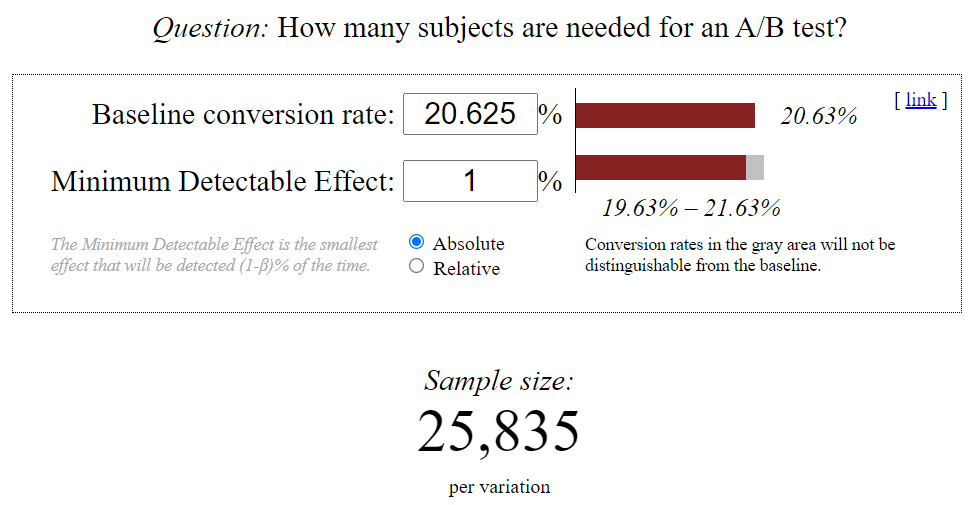

In [3]:
from IPython.display import Image

Image("gross_conversion.png")

In [4]:
gross_conversion_size = int(25835*2*40000/3200)
print(f"Gross conversion control + experimental groups size: {gross_conversion_size}")

Gross conversion control + experimental groups size: 645875


Retention:

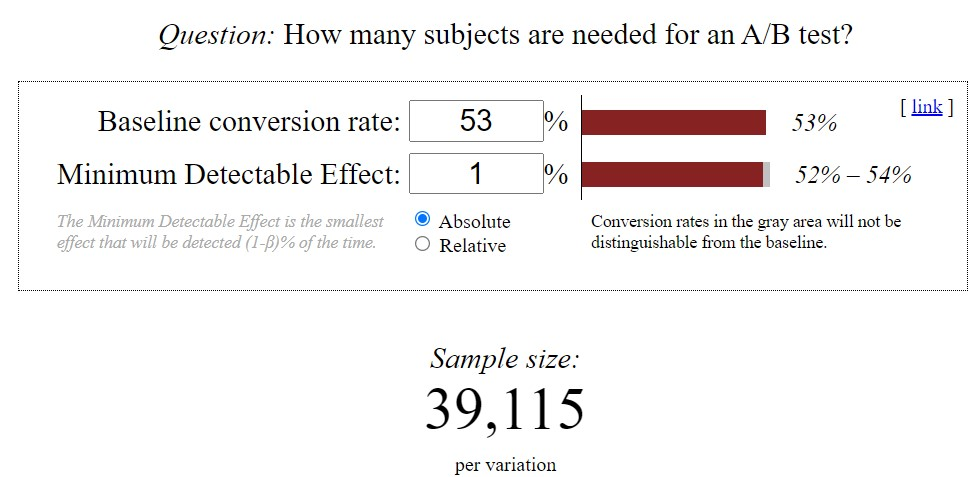

In [5]:
Image("retention.png")

In [6]:
retention_size = int(39115*2*40000/660)
print(f"Retention control + experimental groups size: {retention_size}")

Retention control + experimental groups size: 4741212


Net conversion:

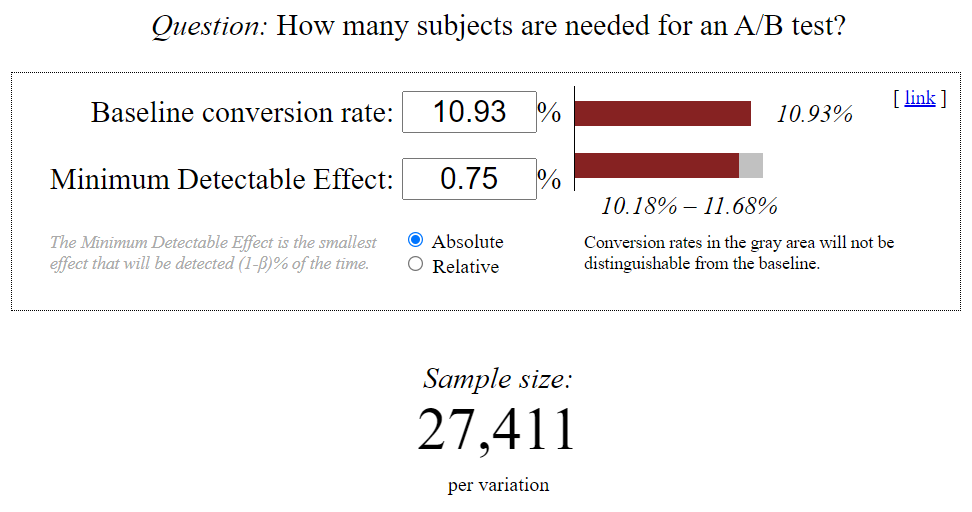

In [7]:
Image("net_conversion.png")

In [8]:
net_conversion_size = int(27411*2*40000/3200)
print(f"Net conversion control + experimental groups size: {net_conversion_size}")

Net conversion control + experimental groups size: 685275


In [9]:
print("Pageviews needed:", max(gross_conversion_size,retention_size,net_conversion_size))

Pageviews needed: 4741212


## Duration and exposure
Minimum duration for each metric (100% of traffic diverted) 

In [10]:
from math import ceil

print("Days for gross coversion:", ceil(gross_conversion_size/cookies_pageviews))
print("Days for retention:", ceil(retention_size/cookies_pageviews))
print("Days for net coversion:", ceil(net_conversion_size/cookies_pageviews))

Days for gross coversion: 17
Days for retention: 119
Days for net coversion: 18


Even with 100% of traffic diverted for the experiment, the amount of days needed to measure appropriately the retention is incredibly high.

Dropping this metric we could decrease the percentage of traffic without increasing evenly the duration of the experiment.

## Sanity checks

Final results available here: https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0

In [11]:
def confidence_interval(std):
    m = 1.96 * std
    return round(0.5 - m, 4), round(0.5 + m, 4)

Number of cookies:

In [12]:
pageviews_control_sum = 345543
pageviews_exp_sum = 344660

std_pageviews = np.sqrt(0.5*0.5/(pageviews_control_sum+pageviews_exp_sum))

ci_min,ci_max = confidence_interval(std_pageviews)
print("Pageviews C.I.:", (ci_min,ci_max))
print("Observed:", round(pageviews_control_sum/(pageviews_exp_sum+pageviews_control_sum), 4))

Pageviews C.I.: (0.4988, 0.5012)
Observed: 0.5006


Number of clicks on 'Start free trial':

In [13]:
click_control_sum = 28378
click_exp_sum = 28325

std_clicks = np.sqrt(0.5*0.5/(click_control_sum+click_exp_sum))

ci_min,ci_max = confidence_interval(std_clicks)
print("Pageviews C.I.:", (ci_min,ci_max))
print("Observed:", round(click_control_sum/(click_exp_sum+click_control_sum), 4))

Pageviews C.I.: (0.4959, 0.5041)
Observed: 0.5005


Click-through-probability:

In [14]:
ctp_control = click_control_sum / pageviews_control_sum
ctp_exp = click_exp_sum / pageviews_exp_sum

d_hat = ctp_exp - ctp_control
ctp_pool=(click_control_sum+click_exp_sum)/(pageviews_control_sum+pageviews_exp_sum)
std_ctp = np.sqrt((ctp_pool*(1-ctp_pool))*(1/pageviews_control_sum + 1/pageviews_exp_sum))

ci_min,ci_max = round(-1.96*std_ctp,4), round(1.96*std_ctp,4)
print("Pageviews C.I.:", (ci_min,ci_max))
print("Observed:", round(d_hat, 4))

Pageviews C.I.: (-0.0013, 0.0013)
Observed: 0.0001


## Effect size test
For each evaluation metric, compute a 95% confidence interval around the difference, in order to evaluate if the difference between the control and the experimental group is statistically significant or not.

Gross conversion:

In [15]:
# d_min=0.01

clicks_cont_sum = 17293 # sum of control clicks when even the enrollments are tracked
clicks_exp_sum = 17260 # sum of experiment clicks when even the enrollments are tracked

enroll_cont_sum = 3785
enroll_exp_sum = 3423

p_pool = (enroll_exp_sum + enroll_cont_sum) / (clicks_exp_sum + clicks_cont_sum)
se_pool = np.sqrt(p_pool * (1-p_pool) * (1/clicks_cont_sum + 1/clicks_exp_sum))

margin = se_pool * 1.96
d_hat = enroll_exp_sum/clicks_exp_sum - enroll_cont_sum/clicks_cont_sum

lower_bound = round(d_hat-margin, 4)
upper_bound = round(d_hat+margin, 4)

print(f"Confidence Interval:{(lower_bound, upper_bound)}")
print("Observed:", round(d_hat, 4))

print ("\nStatistical significance?", upper_bound < 0 or lower_bound > 0, 
       "\nPractical significance? Yes because the CI doesn't include 0.01 or -0.01")

Confidence Interval:(-0.0291, -0.012)
Observed: -0.0206

Statistical significance? True 
Practical significance? Yes because the CI doesn't include 0.01 or -0.01


Retention:

In [16]:
# d_min=0.01

pay_cont_sum = 2033
pay_exp_sum = 1945 

p_pool = (pay_cont_sum + pay_exp_sum) / (enroll_exp_sum + enroll_cont_sum)
se_pool = np.sqrt(p_pool * (1-p_pool) * (1/enroll_cont_sum + 1/enroll_exp_sum))

margin = se_pool * 1.96
d_hat = pay_exp_sum/enroll_exp_sum - pay_cont_sum/enroll_cont_sum

lower_bound = round(d_hat-margin, 4)
upper_bound = round(d_hat+margin, 4)

print(f"Confidence Interval:{(lower_bound, upper_bound)}")
print("Observed:", round(d_hat, 4))

print ("\nStatistical significance?", upper_bound < 0 or lower_bound > 0, 
       "\nPractical significance? No because the CI includes 0.01")

Confidence Interval:(0.0081, 0.0541)
Observed: 0.0311

Statistical significance? True 
Practical significance? No because the CI includes 0.01


Net conversion:

In [17]:
# d_min=0.0075

clicks_cont_sum = 17293 # sum of control clicks when even the payments are tracked
clicks_exp_sum = 17260 # sum of experiment clicks when even the payments are tracked


p_pool = (pay_exp_sum + pay_cont_sum) / (clicks_exp_sum + clicks_cont_sum)
se_pool = np.sqrt(p_pool * (1-p_pool) * (1/clicks_cont_sum + 1/clicks_exp_sum))

margin = se_pool * 1.96
d_hat = pay_exp_sum/clicks_exp_sum - pay_cont_sum/clicks_cont_sum

lower_bound = round(d_hat-margin, 4)
upper_bound = round(d_hat+margin, 4)

print(f"Confidence Interval:{(lower_bound, upper_bound)}")
print("Observed:", round(d_hat, 4))

print ("\nStatistical significance?", upper_bound < 0 or lower_bound > 0, 
       "\nPractical significance? No")

Confidence Interval:(-0.0116, 0.0019)
Observed: -0.0049

Statistical significance? False 
Practical significance? No


## Sign test
For each of your evaluation metrics, do a sign test using the day-by-day data, and report the p-value of the sign test and whether the result is statistically significant.

Gross conversion:

In [18]:
from scipy.stats import binom_test

# ratio between enrollments and clicks day-by-day:
enroll_click_ratio_cont = [0.1950509461, 0.188703466, 0.1837183718,0.1866028708,0.1947431302,0.1676792224,0.1951871658,0.1740506329,0.1895803184,0.1916376307,0.2260668973,0.1933174224,0.1909774436,0.3268945022,0.2547033285,0.2274011299,0.3069828722,0.2092391304,0.2652232747,0.227520436,0.2464589235,0.2290748899,0.2972582973]
enroll_click_ratio_exp = [0.1530612245,0.1477707006,0.1640271493,0.1668681983,0.1682692308,0.1637055838,0.1628205128,0.1441717791,0.1721664275,0.1779069767,0.1655092593,0.1598002497,0.1900311526,0.2783357245,0.1898355755,0.2207792208,0.2762645914,0.2201086957,0.2764786795,0.2843406593,0.2520775623,0.2043165468,0.2513812155]

gc_diff = sum(e>c for e,c in zip(enroll_click_ratio_exp, enroll_click_ratio_cont))

print("Num. exp ratio > control ratio:", gc_diff)

gc_p_value = binom_test(gc_diff, n= len(enroll_click_ratio_cont), p=0.5)

print("Is the difference statistically significant?", gc_p_value < 0.05)
print("p-value:", gc_p_value)

Num. exp ratio > control ratio: 4
Is the difference statistically significant? True
p-value: 0.0025994777679443364


Retention:

In [19]:
# ratio between payments and enrollments day-by-day:
pay_enrolls_ratio_cont = [0.5223880597,0.4761904762,0.5688622754,0.6730769231,0.3926380368,0.5942028986,0.5205479452,0.6363636364,0.4580152672,0.5878787879,0.5357142857,0.5679012346,0.4409448819,0.5545454545,0.7272727273,0.6459627329,0.5321888412,0.5909090909,0.4387755102,0.4491017964,0.5804597701,0.5961538462,0.3252427184]
pay_enrolls_ratio_exp = [0.3238095238,0.7844827586,0.5448275862,0.6666666667,0.6714285714,0.4728682171,0.3464566929,0.6595744681,0.6416666667,0.6405228758,0.4965034965,0.546875,0.5573770492,0.4845360825,0.6377952756,0.660130719,0.558685446,0.7407407407,0.4776119403,0.3236714976,0.6758241758,0.7042253521,0.5659340659]

ret_diff = sum(e>c for e,c in zip(pay_enrolls_ratio_exp, pay_enrolls_ratio_cont))

print("Num. exp ratio > control ratio:", ret_diff)

ret_p_value = binom_test(ret_diff, n= len(pay_enrolls_ratio_cont), p=0.5)

print("Is the difference statistically significant?", ret_p_value < 0.05)
print("p-value:", ret_p_value)

Num. exp ratio > control ratio: 13
Is the difference statistically significant? False
p-value: 0.6776394844055175


Net conversion:

In [20]:
# ratio between payments and enrollments day-by-day:
pay_clicks_ratio_cont = [0.1018922853,0.08985879332,0.104510451,0.1255980861,0.07646356033,0.09963547995,0.1016042781,0.1107594937,0.08683068017,0.112659698,0.1211072664,0.1097852029,0.08421052632,0.1812778603,0.1852387844,0.1468926554,0.163372859,0.1236413043,0.1163734777,0.1021798365,0.1430594901,0.1365638767,0.09668109668]
pay_clicks_ratio_exp = [0.04956268222,0.1159235669,0.08936651584,0.1112454655,0.1129807692,0.07741116751,0.05641025641,0.09509202454,0.1104734577,0.1139534884,0.08217592593,0.08739076155,0.1059190031,0.1348637016,0.1210762332,0.1457431457,0.1543450065,0.1630434783,0.1320495186,0.09203296703,0.1703601108,0.1438848921,0.1422651934,]

nc_diff = sum(e>c for e,c in zip(pay_clicks_ratio_exp, pay_clicks_ratio_cont))

print("Num. exp ratio > control ratio:", nc_diff)

nc_p_value = binom_test(nc_diff, n= len(pay_clicks_ratio_cont), p=0.5)

print("Is the difference statistically significant?", nc_p_value < 0.05)
print("p-value:", nc_p_value)

Num. exp ratio > control ratio: 10
Is the difference statistically significant? False
p-value: 0.6776394844055175


## Final thoughts

I would recommend not to deploy this change. +
We had to achieve two objectives in order to launch the change - 1) reduce the number of frustrated students who left the free trial because they didn't have enough time 2) without significantly reducing the number of students who complete the free trial and make at least one payment.

- There was a statistically and practically significant decrease in gross conversion; so we would decrease the number of students who complete check out because the expectations were correctly set up front and the frustrated students are already filtered out. This is a good point.

- The net conversion was not statistically significant. Looking closely to the data, it's even possible that the number of students who complete the free trial and make at least one payment would be reduced. This is not desirable because would lead to a potential loss of incomes.

- We have not enough data to draw conclusions about the retention. So, we do not know if enrolled students would be disappointed in the learning process less and make more payments or would not.